In [1]:
import glob
import h5py
import librosa
import numpy as np
import os
import scipy.signal
import sys
import tqdm
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sys.path.append("..")
import localmodule

n_species = 10

# t-2 Voice Activity Detection function
def detect_activity(y, sr,
        n_mels=128, fmin=1000, fmax=11025, 
        hop_length=512, gain=0.8, bias=10, power=0.25, pcen_time_constant=0.06, eps=1e-06,
        medfilt_time_constant=None, normalized=True,
        peak_threshold=0.45, activity_threshold=0.2):
    
    # 1. Compute mel-frequency spectrogram
    melspec = librosa.feature.melspectrogram(
        y, sr=sr, fmin=fmin, fmax=fmax, hop_length=hop_length,
        n_mels=n_mels)
    
    # 2. Compute per-channel energy normalization (PCEN-SNR)
    pcen = librosa.core.pcen(melspec, sr=sr, gain=gain, bias=bias,
        power=power, hop_length=hop_length,
        time_constant=pcen_time_constant, eps=eps)
    
    # 3. compute PCEN-SNR detection function
    pcen_snr = np.max(pcen,axis=0) - np.min(pcen,axis=0)
    pcen_snr = librosa.power_to_db(pcen_snr / np.median(pcen_snr))
    if normalized:
        pcen_snr = pcen_snr / np.max(pcen_snr)
        
    # 4. Apply median filtering.
    if medfilt_time_constant is not None:
        medfilt_hops = medfilt_time_constant * sr / hop_length
        kernel_size = max(1, 1 + 2 * round(medfilt_hops - 0.5))
        pcen_snr = scipy.signal.medfilt(pcen_snr, kernel_size=kernel_size)
    
    # 5. Extract active segments.
    activity, start, end = threshold_activity(
        pcen_snr, peak_threshold, activity_threshold)
    
    # 6. Convert indices to seconds.
    start_times = np.round(np.array(start) * hop_length / sr, 3)
    end_times = np.round(np.array(end) * hop_length / sr, 3)
    
    return start_times, end_times, pcen


def threshold_activity(x, Tp, Ta):
    locs = scipy.signal.find_peaks(x,height = Tp)[0]
    y = (x > Ta) * 1
    act = np.diff(y)
    u = np.where(act == 1)[0]
    d = np.where(act == -1)[0]
    signal_length = len(x)
    
    if u.any():

        if d[0] < u[0]:
            u = np.insert(u, 0, 0)

        if d[-1] < u[-1]:
            d = np.append(d, signal_length-1)

        starts = []
        ends = []

        activity = np.zeros(signal_length,)

        for candidate_up, candidate_down in zip(u, d):
            candidate_segment = range(candidate_up, candidate_down)
            peaks_in_segment = [x in candidate_segment for x in locs]
            is_valid_candidate = np.any(peaks_in_segment)
            if is_valid_candidate:
                starts.append(candidate_up)
                ends.append(candidate_down)
                activity[candidate_segment] = 1.0

        starts = np.array(starts)
        ends = np.array(ends)
    
    else:
        activity, starts, ends = [], [], []

    return activity, starts, ends

In [2]:
data_dir = localmodule.get_data_dir()
participant_paths = glob.glob("imitations_participant*.mat")
participant_paths.sort()
n_participants = len(participant_paths)
n_imitations = 100
imitation_matrix = []
species_matrix = []

for participant_path in tqdm.tqdm(participant_paths):
    imitation_list = []
    species_list = []
    
    with h5py.File(participant_path, 'r') as h5_file:
        for i in range(n_imitations):
            imitation_waveform = h5_file['#refs#'][
                h5_file["imitations"]["imitationAudio"][i][0]][0]
            species = int(h5_file['#refs#'][
                h5_file["imitations"]["species"][i][0]][0][0])
            imitation_list.append(imitation_waveform)
            species_list.append(species)
        imitation_matrix.append(imitation_list)
        species_matrix.append(species_list)
imitation_matrix = np.array(imitation_matrix)
species_matrix = np.array(species_matrix)

stimuli_waveform = []
with h5py.File(participant_paths[0], 'r') as h5_file:
    for i in range(n_imitations):
        stimulus_waveform = h5_file["#refs#"][h5_file["imitations"]["stimulusAudio"][i][0]][0]
        stimuli_waveform.append(stimulus_waveform)

100%|██████████| 17/17 [00:13<00:00,  1.30it/s]


In [3]:
sr = 44100
medfilt_time_constant = .1
stimuli_counts = np.zeros((n_imitations,))
imitation_counts = np.zeros((n_participants, n_imitations))

for stimulus_id, stimulus_waveform in tqdm.tqdm(enumerate(stimuli_waveform)):
    starts, stops, _ = detect_activity(stimulus_waveform, sr,
            medfilt_time_constant=medfilt_time_constant)
    stimuli_counts[stimulus_id] = len(starts)
    
    for participant_id in range(n_participants):
        starts, stops, _ = detect_activity(imitation_matrix[participant_id, stimulus_id], sr,
            medfilt_time_constant=medfilt_time_constant)
        imitation_counts[participant_id, stimulus_id] = len(starts)

100it [00:40,  2.24it/s]


/home/kendra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


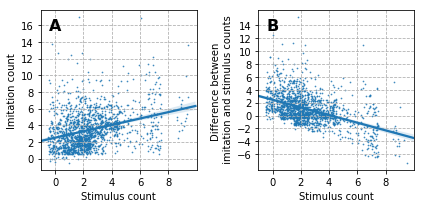

In [5]:
# SCATTER PLOT
gridsize=60
marker_size = 2
jitter = .5
xticks = range(0, 10, 2)
yticks_im = range(0, 18, 2)
yticks_diff = range(-6, 16, 2)
confidence_interval = 95

plt.figure(figsize=(6,3))

ax1 = plt.subplot(1,2,1)
ax1.text(0.05, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

sns.regplot(
    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) \
        + np.random.rand((n_participants*n_imitations)) - jitter,
    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - jitter,  
    marker='.', scatter_kws={'s':marker_size}, ci=confidence_interval)

plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.xlim((-1, 10))
plt.grid(linestyle='--')

################################################################################
# DIFFERENCE BETWEEN STIMULUS & IMITATION COUNTS VS. STIMULUS COUNTS
ax3 = plt.subplot(1,2,2)
ax3.text(0.05, .95, 'B', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

imit_counts = np.ravel(imitation_counts)
stim_counts = np.ravel(np.tile(stimuli_counts, (n_participants, 1)))
diff = imit_counts - stim_counts

sns.regplot(
        stim_counts + np.random.rand((n_imitations * n_participants)) - jitter, 
        diff + np.random.rand((n_imitations * n_participants)) - jitter,  
        marker='.', scatter_kws={'s':marker_size}, ci=confidence_interval) #, fit_reg=False)

plt.xlabel("Stimulus count")
plt.ylabel("Difference between \n imitation and stimulus counts")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_diff)
plt.xlim((-1, 10))
plt.grid(linestyle='--')


plt.tight_layout()
plt.savefig("vihar2019_segmentation_scatters.png", dpi=1000, bbox_inches="tight")
plt.savefig("vihar2019_segmentation_scatters.eps", bbox_inches="tight")

## Extras

In [ ]:
# SCATTER PLOT
gridsize=60
marker_size = 2
jitter = .5
xticks = range(0, 10, 2)
yticks_im = range(0, 18, 2)
yticks_diff = range(-6, 16, 2)
confidence_interval = 95

plt.figure(figsize=(12,4.2))

ax1 = plt.subplot(1,4,1)
ax1.text(0.05, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

sns.regplot(
    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) \
        + np.random.rand((n_participants*n_imitations)) - jitter,
    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - jitter,  
    marker='.', scatter_kws={'s':marker_size}, ci=confidence_interval)

plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.xlim((-1, 10))
plt.grid(linestyle='--')

################################################################################
# DIFFERENCE BETWEEN STIMULUS & IMITATION COUNTS VS. STIMULUS COUNTS
ax3 = plt.subplot(1,4,2)
ax3.text(0.05, .95, 'B', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

imit_counts = np.ravel(imitation_counts)
stim_counts = np.ravel(np.tile(stimuli_counts, (n_participants, 1)))
diff = imit_counts - stim_counts

sns.regplot(
        stim_counts + np.random.rand((n_imitations * n_participants)) - jitter, 
        diff + np.random.rand((n_imitations * n_participants)) - jitter,  
        marker='.', scatter_kws={'s':marker_size}, ci=confidence_interval) #, fit_reg=False)

plt.xlabel("Stimulus count")
plt.ylabel("Difference between \n imitation and stimulus counts")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_diff)
plt.xlim((-1, 10))
plt.grid(linestyle='--')

################################################################################
# WITH BIRDWATCHING EXPERIENCE AS COLOR
ax3 = plt.subplot(1,4,3)
ax3.text(0.05, .95, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

metadata_path = 'BirdVox-imitation_metadata.mat'
with h5py.File(metadata_path) as h5_file:
    birding_experiences = [
        h5_file["#refs#"][h5_file["meta"]["participants"]["birdingExperience"][i][0]][0][0]
        for i in range(n_participants)]
    birding_experiences = np.array(birding_experiences)

levels_corrected = np.array([1, 2, 3, 4])
levels_corrected_2 = np.array([1, 1, 2, 2])
correction = levels_corrected

levels_in_data = np.array([73, 79, 82, 80])
for i, level in enumerate(levels_in_data):
    birding_experiences[birding_experiences == level] = correction[i]
    
colors = ['lightgreen', 'mediumaquamarine', 'C', 'teal']
experiences = ['No birdwatching experience', 'Occasional amateur birdwatcher', \
               'Regular amateur birdwatcher', 'Professional ornithologist' ]

for i, birding_id in enumerate(np.unique(correction)):
    ptp_subset = birding_experiences == birding_id
    stim_counts = np.ravel(np.tile(stimuli_counts, (sum(ptp_subset), 1)))
    imit_counts = np.ravel(imitation_counts[ptp_subset, :])
    #diff = stim_counts - imit_counts
    diff = imit_counts - stim_counts
    sns.regplot(
        stim_counts + np.random.rand((sum(ptp_subset) * n_imitations)) - .5,
        imit_counts + np.random.rand((sum(ptp_subset) * n_imitations)) - .5,
        fit_reg=True, color=colors[i], scatter_kws={'s':marker_size}, marker='.',
        label=experiences[i], ci=confidence_interval
        )
    
plt.legend(bbox_to_anchor=(1.05, -.25), loc='best', borderaxespad=0., 
           title='Birdwatching experience', frameon=False)

plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.xlim((-1, 10))
plt.grid(linestyle='--')
    

################################################################################
# WITH MUSICIANSHIP AS COLOR
ax3 = plt.subplot(1,4,4)
ax3.text(0.05, .95, 'D', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

metadata_path = 'BirdVox-imitation_metadata.mat'
with h5py.File(metadata_path) as h5_file:
    musicianship = [
        h5_file["#refs#"][h5_file["meta"]["participants"]["musicianship"][i][0]][0][0]
        for i in range(n_participants)]
    musicianship = np.array(birding_experiences)

    
levels_corrected = np.array([1, 2, 3])
levels_corrected_2 = np.array([1, 2, 2])
correction = levels_corrected

levels_in_data = np.array([78, 65, 80])
for i, level in enumerate(levels_in_data):
    musicianship[musicianship == level] = correction[i]
    
colors = ['gold', 'darkorange', 'firebrick']
experiences = ['Nonmusician', 'Amateur musician', 'Professional musician']

for i, musicianship_id in enumerate(np.unique(correction)):
    ptp_subset = musicianship == musicianship_id
    stim_counts = np.ravel(np.tile(stimuli_counts, (sum(ptp_subset), 1)))
    imit_counts = np.ravel(imitation_counts[ptp_subset, :])
    #diff = stim_counts - imit_counts
    diff = imit_counts - stim_counts
    sns.regplot(
        stim_counts + np.random.rand((sum(ptp_subset) * n_imitations)) - .5,
        imit_counts + np.random.rand((sum(ptp_subset) * n_imitations)) - .5,
        fit_reg=True, color=colors[i], scatter_kws={'s':marker_size}, marker='.',
        label=experiences[i], ci=confidence_interval
        )

plt.legend(bbox_to_anchor=(1.05, -.25), loc='best', borderaxespad=0., 
           title='Musicianship', frameon=False)

plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.xlim((-1, 10))
plt.grid(linestyle='--')

plt.tight_layout()
#plt.savefig("vihar2019_segmentation_scatters.png", dpi=1000, bbox_inches="tight")
#plt.savefig("vihar2019_segmentation_scatters.eps", bbox_inches="tight")


In [41]:
np.unique(corr# multiple linear regression

y = np.ravel(imitation_counts)
x0 = np.matlib.repmat(stimuli_counts, 100, n_participants)

print(y.shape, x0.shape)
print(x0)
print(stimuli_counts)ection)[0]

1

/home/kendra/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


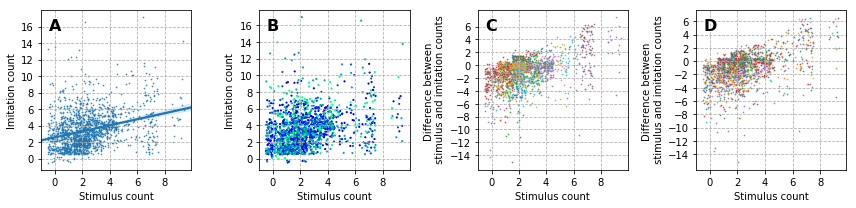

In [63]:
# SCATTER PLOT
gridsize=60
marker_size = 5
jitter = .5
xticks = range(0, 10, 2)
yticks_im = range(0, 18, 2)
yticks_diff = range(-14, 8, 2)

plt.figure(figsize=(12,3))

ax1 = plt.subplot(1,4,1)
ax1.text(0.05, .95, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

#plt.hexbin(
#    np.ravel(np.tile(stimuli_counts, (n_participants, 1))),
#    np.ravel(imitation_counts),
#    gridsize=gridsize, cmap=cmap)
# cb = plt.colorbar(label='count in bin')

sns.regplot(
    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) \
        + np.random.rand((n_participants*n_imitations)) - jitter,
    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - jitter,  
    marker='.', scatter_kws={'s':2})

#plt.scatter(
#    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) + np.random.rand((n_participants*n_imitations)) - 0.5,
#    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - 0.5,
#    marker='.', alpha=1/3, s=marker_size)
#plt.plot([0, 25], [0, 25], '--', color='orange', linewidth=3.0)
#plt.xlim(0, 25)
#plt.ylim(0, 25)
plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.grid(linestyle='--')

################################################################################
# WITH BIRDWATCHING EXPERIENCE AS COLOR
ax3 = plt.subplot(1,4,2)
ax3.text(0.05, .95, 'B', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top')

metadata_path = 'BirdVox-imitation_metadata.mat'
with h5py.File(metadata_path) as h5_file:
    birding_experiences = [
        h5_file["#refs#"][h5_file["meta"]["participants"]["birdingExperience"][i][0]][0][0]
        for i in range(n_participants)]
    birding_experiences = np.array(birding_experiences)

levels_corrected = np.array([1, 2, 3, 4])
levels_corrected_2 = np.array([1, 1, 2, 2])
levels_in_data = np.array([73, 79, 82, 80])
for i, level in enumerate(levels_in_data):
    birding_experiences[birding_experiences == level] = levels_corrected[i]

plt.scatter(
    np.ravel(np.tile(stimuli_counts, (n_participants, 1))) \
        + np.random.rand((n_participants*n_imitations)) - jitter,
    np.ravel(imitation_counts) + np.random.rand((n_participants*n_imitations)) - jitter,
    c=np.ravel(np.tile(birding_experiences, (n_imitations,1)).T),
    cmap='winter',
    marker='.', s=marker_size)

plt.xlabel("Stimulus count")
plt.ylabel("Imitation count")
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_im)
plt.grid(linestyle='--')
#cbar = plt.colorbar()
#cbar.ax.set_yticklabels([])
#cbar.ax.tick_params(length=0)

################################################################################
# WITH SPECIES AS COLOR

ax1 = plt.subplot(1,4,3)
ax1.text(0.05, .95, 'C', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

with h5py.File(metadata_path) as h5_file:
    species_strings = [
        " ".join([x.capitalize() for x in
        "".join(list(map(chr, h5_file["#refs#"][h5_file["meta"]["species"]["speciesName"][i][0]][:]))).split("_")])
         for i in range(n_species)
    ]

for species_id in np.arange(1,n_species+1):
    species_inds = species_matrix[0,:] == species_id
    stim_counts_spc = np.ravel(np.tile(stimuli_counts[species_inds], (n_participants, 1)))
    imit_counts_spc = np.ravel(imitation_counts[:, species_inds]) 
    diff_spc =  stim_counts_spc - imit_counts_spc
    sns.regplot(
        stim_counts_spc + np.random.rand((n_participants*n_species)) - jitter, 
        diff_spc + np.random.rand((n_participants*n_species)) - jitter,  
        marker='.', scatter_kws={'s':2}, fit_reg=False)
plt.xlabel('Stimulus count')
plt.ylabel('Difference between \n stimulus and imitation counts')
plt.grid(linestyle='--')
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_diff)

#cbar.set_label('birdwatching experience')


################################################################################
# WITH PARTICIPANT AS COLOR
ax1 = plt.subplot(1,4,4)
ax1.text(0.05, .95, 'D', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top')

for participant_id in np.arange(n_participants-1):
    diff_ptp = stimuli_counts - imitation_counts[participant_id, :]
    sns.regplot(
        stimuli_counts + np.random.rand((n_imitations)) - jitter, 
        diff_ptp + np.random.rand((n_imitations)) - jitter,  
        marker='.', scatter_kws={'s':2}, fit_reg=False)
plt.xlabel('Stimulus count')
plt.ylabel('Difference between \n stimulus and imitation counts')
plt.grid(linestyle='--')
plt.gca().set_xticks(xticks)
plt.gca().set_yticks(yticks_diff)


plt.tight_layout()
#plt.savefig("vihar2019_segmentation_scatters.png", dpi=1000, bbox_inches="tight")
#plt.savefig("vihar2019_segmentation_scatters.eps", bbox_inches="tight")

In [15]:
stimuli_counts.shape

(100,)

/home/kendra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kendra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


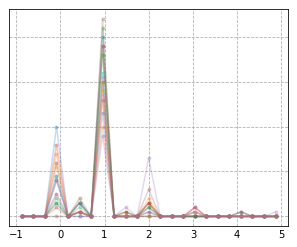

In [26]:
# PER-PARTICIPANT HISTOGRAM
plt.figure(figsize=(5, 4))
count_ratios = (imitation_counts / np.tile(stimuli_counts, (n_participants, 1)))

for participant_id in range(n_participants):
    bin_y, bin_edges = np.histogram((count_ratios[participant_id, :]), bins=np.linspace(-1, 5, 24));
    bin_x = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    plt.plot(bin_x, bin_y, '.-', alpha=0.25)
    
#plt.xlim(-1, 10)
#plt.ylim(0, 32)
#plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().tick_params(length=0)
plt.grid(linestyle='--')


#plt.savefig("vihar2019_participant_histogram.png", dpi=1000, bbox_inches="tight")
#plt.savefig("vihar2019_participant_histogram.eps", bbox_inches="tight")